---

# <b> 창원 AI 아카데미: 데이터 분석 해커톤

* 일시: 2023년 7월 10일 ~ 12일
* 참가자: 백종환 </b>

<br>

---

---
# <b> * 문제 * </b>

### <b> *2012년부터 2021년까지의 창원시 표준지공시지가를 이용하여 2022년 창원시 표준지공시지가를 예측하시오.* </b>
---

## <b> 1. 데이터 전처리 </b>

> 필요 **라이브러리** 호출

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import iplot, init_notebook_mode

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


### 파일 불러오기
> 다수의 csv 파일에서 필요한 부분만 추출해서 하나로 합침.

In [20]:
df_list = []
for i in range(2012, 2022):
    if i == 2016:
        df = pd.read_csv("2016년 표준지 공시지가.csv", encoding='cp949')
        df['시도명'] = df['시도']
        df['시군구명'] = df['시군구.1']
        df['소재지'] = df['동리']
        df['지리적위치2'] = df['지리적위치']
        df['형상명'] = df['형상']
        df['지세명'] = df['지세']
        df['용도지역1'] = df['용도지역']
        df = df.drop(['시도', '시군구.1', '동리', '지리적위치', '형상', '지세', '용도지역', '읍면', '본번지.1', '부번지.1', '지번구분.1','부번지'], axis=1)
        df['연도'] = pd.to_datetime(i, format='%Y').year
        df_list.append(df)
    else:
        try:
            df = pd.read_csv(f"{i}년 표준지 공시지가.csv", encoding='cp949')
            df['연도'] = pd.to_datetime(i, format='%Y').year
            df_list.append(df)
        except UnicodeDecodeError:
            df = pd.read_csv(f"{i}년 표준지 공시지가.csv", encoding='utf-8')
            df['연도'] = pd.to_datetime(i, format='%Y').year
            df_list.append(df)

data = pd.concat(df_list, ignore_index=True)
data.head()

,일련번호,시군구,읍면동리,지번구분,본번지,부번지,시도명,시군구명,소재지,지목,...,이용상황,주위환경,지세명,형상명,도로교통,공시지가,지리적위치1,지리적위치2,방위,연도
0,1,11110,10100,1,0003,0052,서울특별시,종로구,청운동 3-52,공원,...,공원등,시가지주변 야산지대,급경사지,부정형,세로(불),346000,경기상고,북측 인근,NaN,2012
1,2,11110,10100,1,0004,0015,서울특별시,종로구,청운동 4-15,대,...,단독주택,기존 주택지대,완경사지,사다리형,세로(가),2300000,경기상고,북서측 인근,북동향,2012
2,3,11110,10100,1,0008,0009,서울특별시,종로구,청운동 8-9,대,...,연립주택,일반 주택지대,급경사지,부정형,세로(가),2150000,청운중학교,서측인근,남향,2012
3,4,11110,10100,1,0015,0012,서울특별시,종로구,청운동 15-12,대,...,단독주택,고급 주택지대,평지,사다리형,소로각지,3280000,청운중학교,북서측인근,서향,2012
4,5,11110,10100,1,0015,0013,서울특별시,종로구,청운동 15-13,대,...,단독주택,고급 주택지대,완경사지,세로장방형,세로(가),2880000,경기상고,북측인근,북향,2012


> 2022년도 데이터 불러오기

In [21]:
df_2022 = pd.read_csv("2022년 표준지 공시지가.csv", encoding='utf-8')

df_2022['연도'] = pd.to_datetime(2022, format='%Y').year
df_2022 = df_2022.drop(['용도지역2', '지리적위치1', '지리적위치2', '방위'], axis=1)
df_2022.loc[df_2022['시군구명'].isna(), '시군구명'] = '세종특별자치시'
df_2022 = df_2022.iloc[:, 1:]
df_2022 = df_2022[df_2022['시군구명'].str.contains('창원')]
df_2022.head()

,시군구,읍면동리,지번구분,본번지,부번지,시도명,시군구명,소재지,지목,면적,용도지역1,이용상황,주위환경,지세명,형상명,도로교통,공시지가,연도
465236,48121,10100,1,0028,0000,경상남도,창원의창구,북동 28,대,182.0,제1종일반주거지역,다세대,기존 주택지대,평지,사다리형,소로한면,844500,2022
465237,48121,10100,1,0035,0000,경상남도,창원의창구,북동 35,대,98.0,제1종일반주거지역,단독주택,기존 주택지대,평지,사다리형,세각(불),657000,2022
465238,48121,10100,1,0072,0000,경상남도,창원의창구,북동 72,대,162.0,제1종일반주거지역,단독주택,기존 주택지대,평지,부정형,세로(불),754000,2022
465239,48121,10100,1,0090,0002,경상남도,창원의창구,북동 90-2,대,138.0,제1종일반주거지역,단독주택,기존 주택지대,평지,부정형,소로한면,909500,2022
465240,48121,10100,1,0100,0002,경상남도,창원의창구,북동 100-2,대,180.0,제1종일반주거지역,단독주택,기존 주택지대,평지,부정형,소로한면,943500,2022


# 창원시 데이터만 불러오기 및 결측치 제거

In [22]:
# 창원시 데이터만 불러오기
original = data.iloc[:, 1:].copy()
original = original.drop(['용도지역2', '지리적위치1', '지리적위치2', '방위', '부번지'], axis=1)
filtered_data = original[(original['시도명'].str.contains('경상남도'))]
filtered_data = filtered_data[filtered_data['시군구명'].str.contains('창원')]
df = filtered_data.copy()
df['가격'] = df['면적'] * df['공시지가']
print(df.isna().sum())
df.head()

시군구      0
읍면동리     0
지번구분     0
본번지      0
시도명      0
시군구명     0
소재지      0
지목       0
면적       0
용도지역1    0
이용상황     0
주위환경     0
지세명      0
형상명      0
도로교통     0
공시지가     0
연도       0
가격       0
dtype: int64


,시군구,읍면동리,지번구분,본번지,시도명,시군구명,소재지,지목,면적,용도지역1,이용상황,주위환경,지세명,형상명,도로교통,공시지가,연도,가격
431093,48121,10100,1,0006,경상남도,창원의창구,북동 6,대,159.0,제1종일반주거지역,단독주택,기존 주택지대,완경사지,사다리형,세각(불),410000,2012,65190000.0
431094,48121,10100,1,0028,경상남도,창원의창구,북동 28,대,182.0,제1종일반주거지역,다세대,기존 주택지대,평지,사다리형,소로한면,540000,2012,98280000.0
431095,48121,10100,1,0072,경상남도,창원의창구,북동 72,대,162.0,제1종일반주거지역,단독주택,기존 주택지대,평지,부정형,세로(불),450000,2012,72900000.0
431096,48121,10100,1,0090,경상남도,창원의창구,북동 90-2,대,147.0,제1종일반주거지역,단독주택,기존 주택지대,평지,부정형,소로한면,555000,2012,81585000.0
431097,48121,10100,1,0100,경상남도,창원의창구,북동 100-2,대,180.0,제1종일반주거지역,단독주택,기존 주택지대,평지,부정형,소로한면,590000,2012,106200000.0


## <b> 2. 탐색적 자료 분석 및 특징 선택 EDA</b>

# 10년간의 공시지가 변화

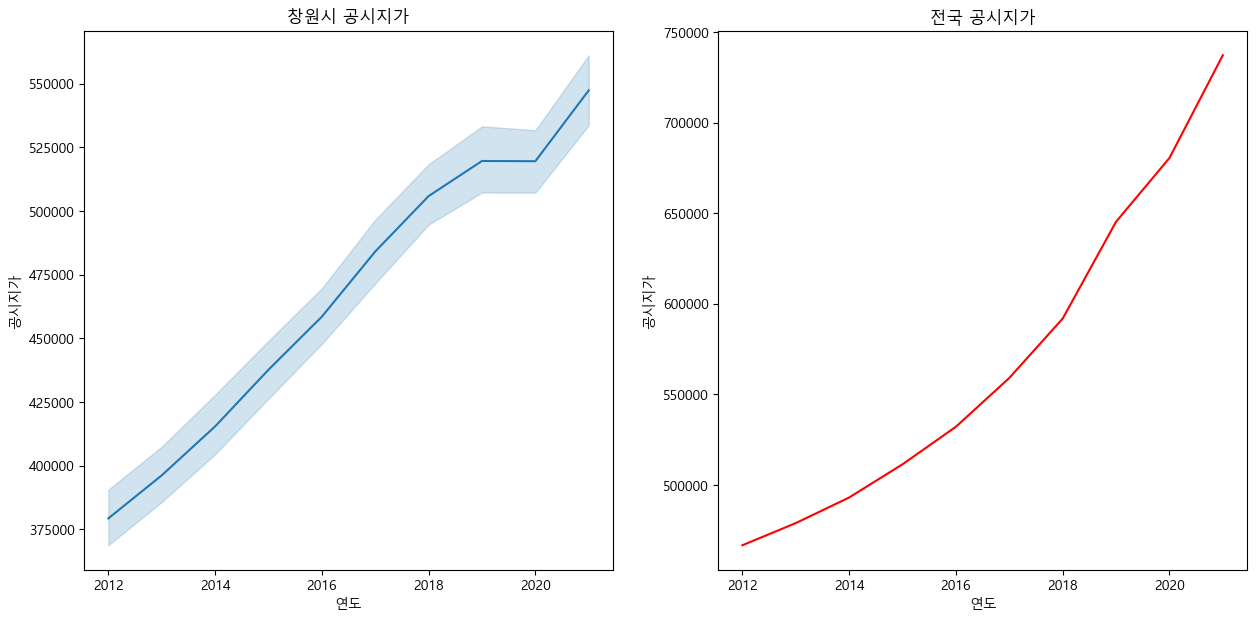

In [6]:
ori = original.groupby('연도')['공시지가'].mean().reset_index()
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.lineplot(x='연도', y='공시지가', data=df, ax=ax[0])
ax[0].set_title('창원시 공시지가')
sns.lineplot(x='연도', y='공시지가', data=ori, ax=ax[1], color='red')
ax[1].set_title('전국 공시지가')
plt.show()

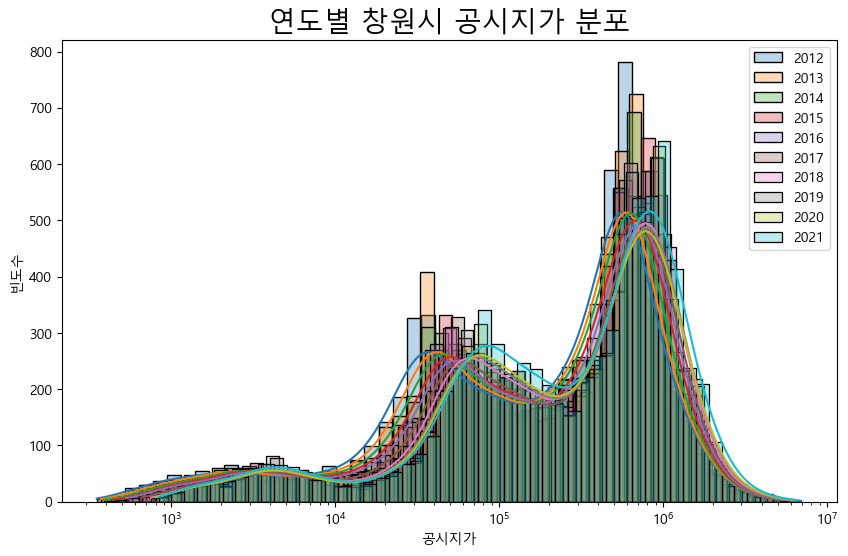

In [44]:
# 연도별 공시지가 분포
plt.figure(figsize=(10, 6))
for year in range(2012, 2022):
    year_data = df[df['연도'] == year]['공시지가']
    sns.histplot(year_data, bins=50, alpha=0.3, label=str(year), kde=True, log_scale=True)
plt.xlabel('공시지가')
plt.ylabel('빈도수')
plt.title('연도별 창원시 공시지가 분포', fontsize=20)
plt.legend()
plt.show()

# 면적과 공시지가의 분포

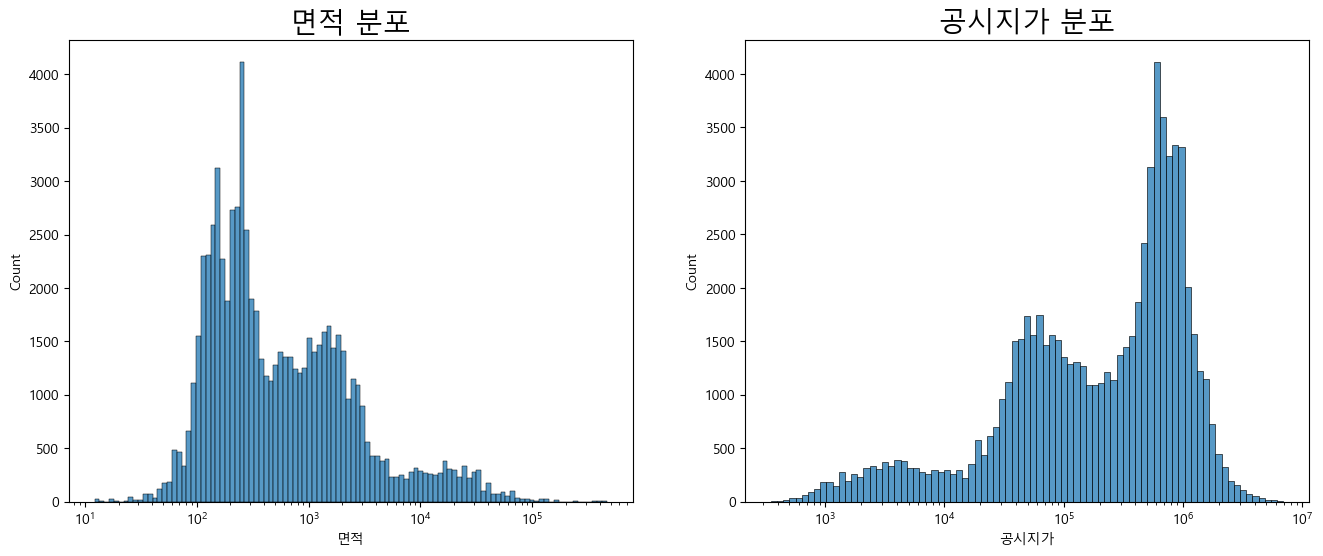

In [43]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))
sns.histplot(df['면적'], ax=ax1, log_scale=True)
ax1.set_title('면적 분포', fontsize=20)
sns.histplot(df['공시지가'], ax=ax2, log_scale=True)
ax2.set_title('공시지가 분포', fontsize=20)
plt.show()

# <u>지목</u>별 분석
> 박스플롯과 원그래프로 공시지가를 시각화하고 분석함.

* 대 : 지적법에서는 영구적 건축물중 주거ㆍ사무실ㆍ점포와 박물관ㆍ극장ㆍ미술관등 문화시설과 이에 접속된 부속시설물의 부지 및 정원과 도시계획사업등 관계법령에 의한 택지조성사업을 목적으로 하는 공사가 준공된 토지의 지목은 대로 한다(지적법시행령 제5조).

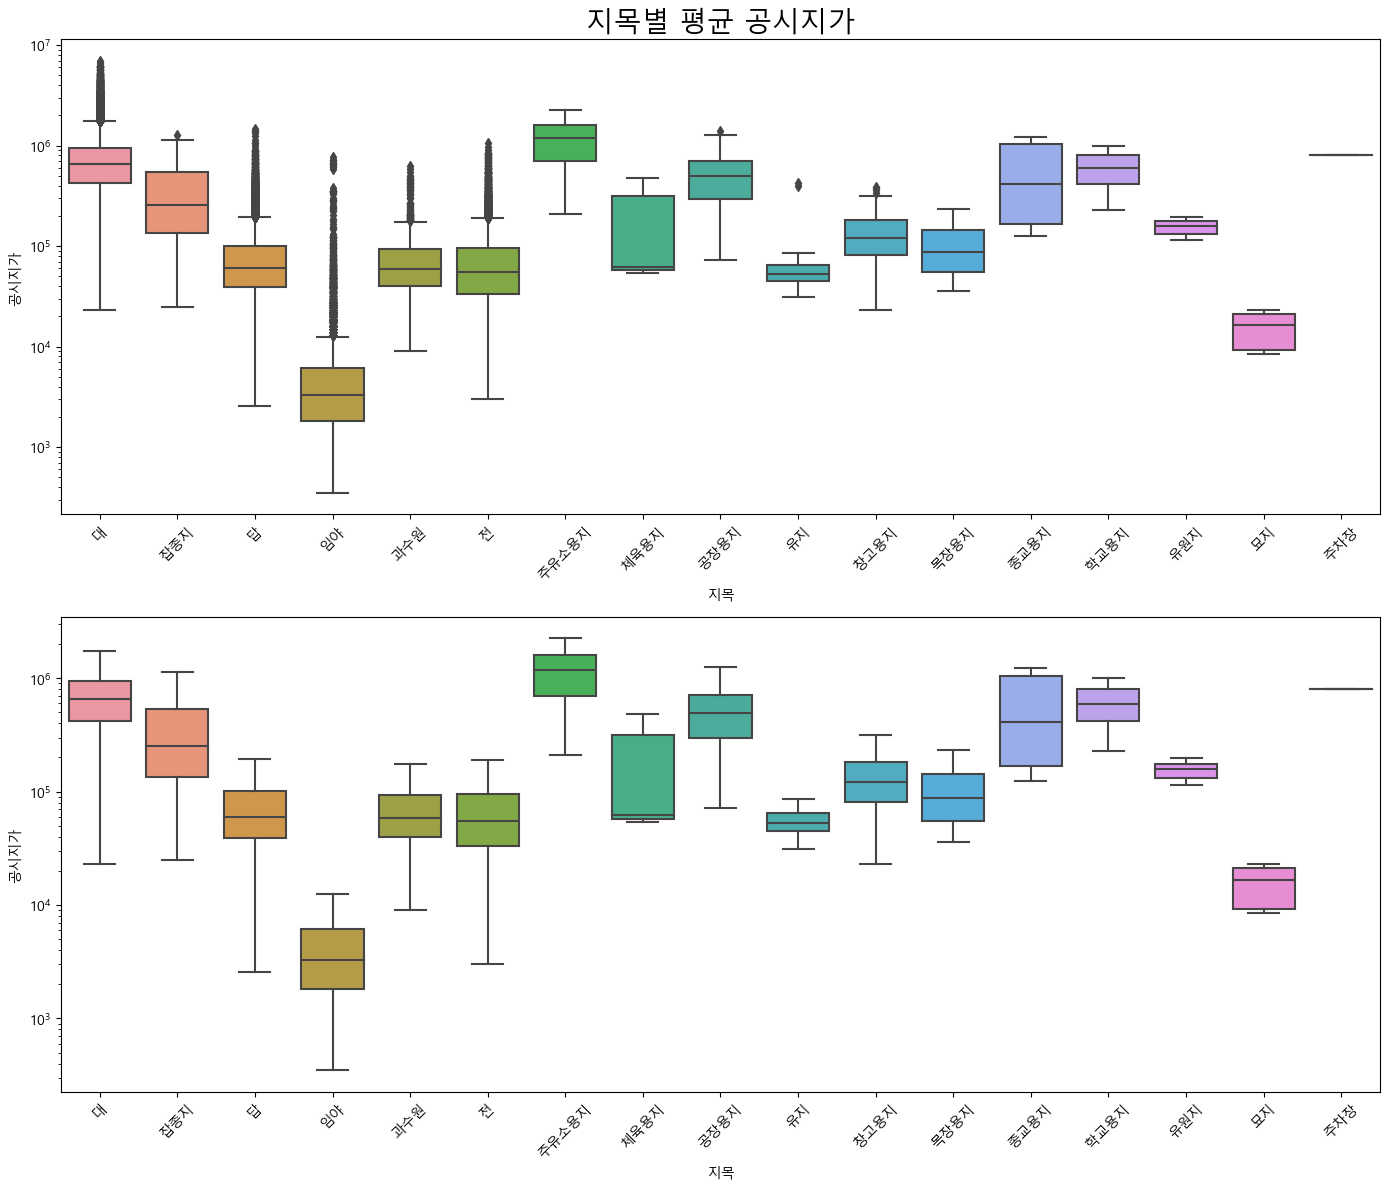

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(14,12))
sns.boxplot(data=df, x='지목', y='공시지가', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('지목별 평균 공시지가', fontsize=20)
axes[0].set_yscale('log')
sns.boxplot(data=df, x='지목', y='공시지가', showfliers=False, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_yscale('log')
plt.tight_layout()
plt.show()

In [68]:
jimok_value = df['지목'].value_counts()

fig = go.Figure(data=[go.Pie(labels=df['지목'].unique(), values=jimok_value, hole=0.4)])
fig.update_layout(width=900, height=800, title={
    'text': '창원시 지목별 분포',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 20}
})
# Display the figure in the notebook
fig.show()

In [46]:
jimok_value = df.groupby('지목')['면적'].sum()

fig = go.Figure(data=[go.Pie(labels=df['지목'].unique(), values=jimok_value, hole=0.4)])
fig.update_layout(width=900, height=800, title={
    'text': '창원시 지목별 면적 분포',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 20}
})
# Display the figure in the notebook
fig.show()

# 용도지역별 분석

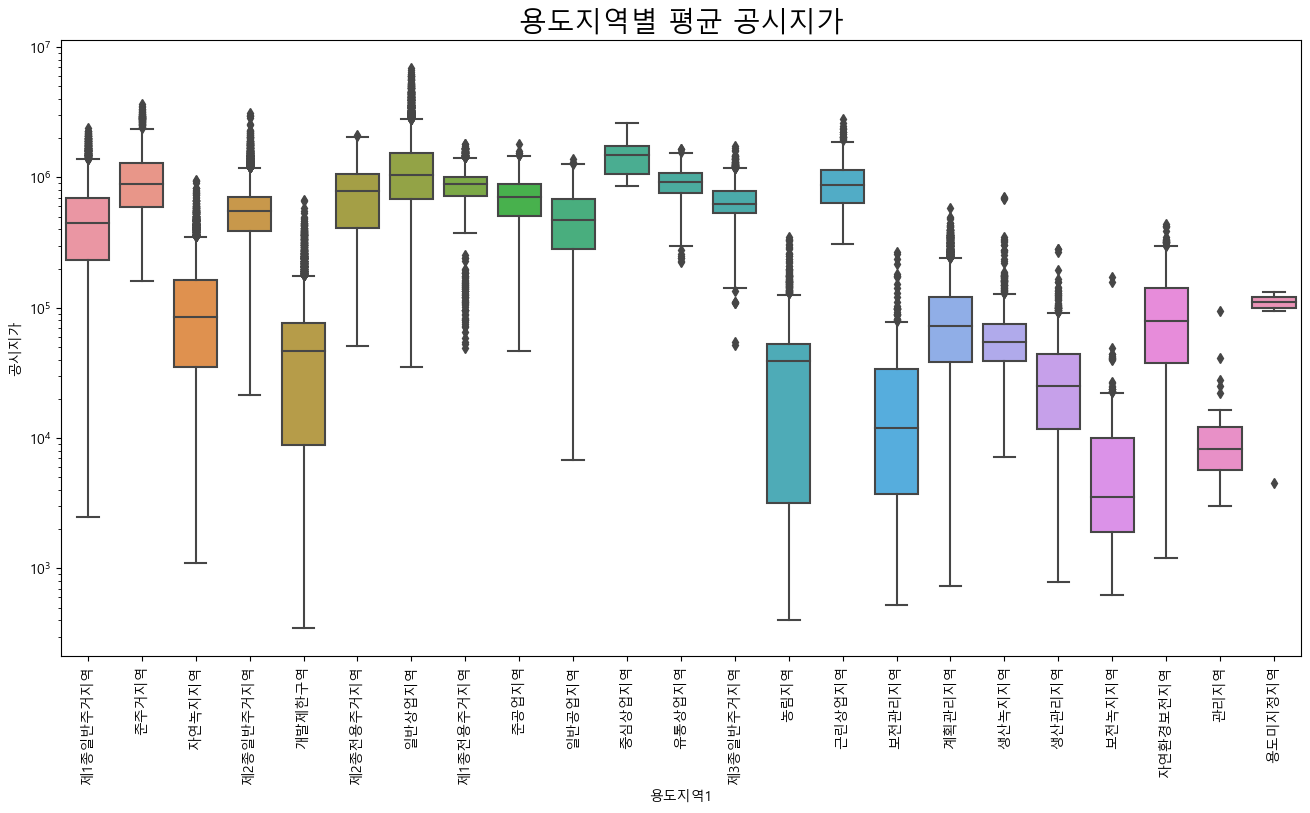

In [26]:
df['용도지역1']
plt.figure(figsize=(16,8))
sns.boxplot(data=df, x='용도지역1', y='공시지가')
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('용도지역별 평균 공시지가', fontsize=20)
plt.show()

In [70]:
yongdo_value = df['용도지역1'].value_counts()
fig = go.Figure(data=[go.Pie(labels=df['용도지역1'].unique(), values=yongdo_value, hole=0.4, pull=[0,0,0,0,0,0,0.2,0,0,0,0.2])])
fig.update_layout(width=1000, height=900, title={
    'text': '창원시 용도지역별 분포',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 35}
})

fig.show()

# 지세, 형상, 도로교통에 따른 분석
> 세 가지의 조건으로 공시지가 분석 및 그래프

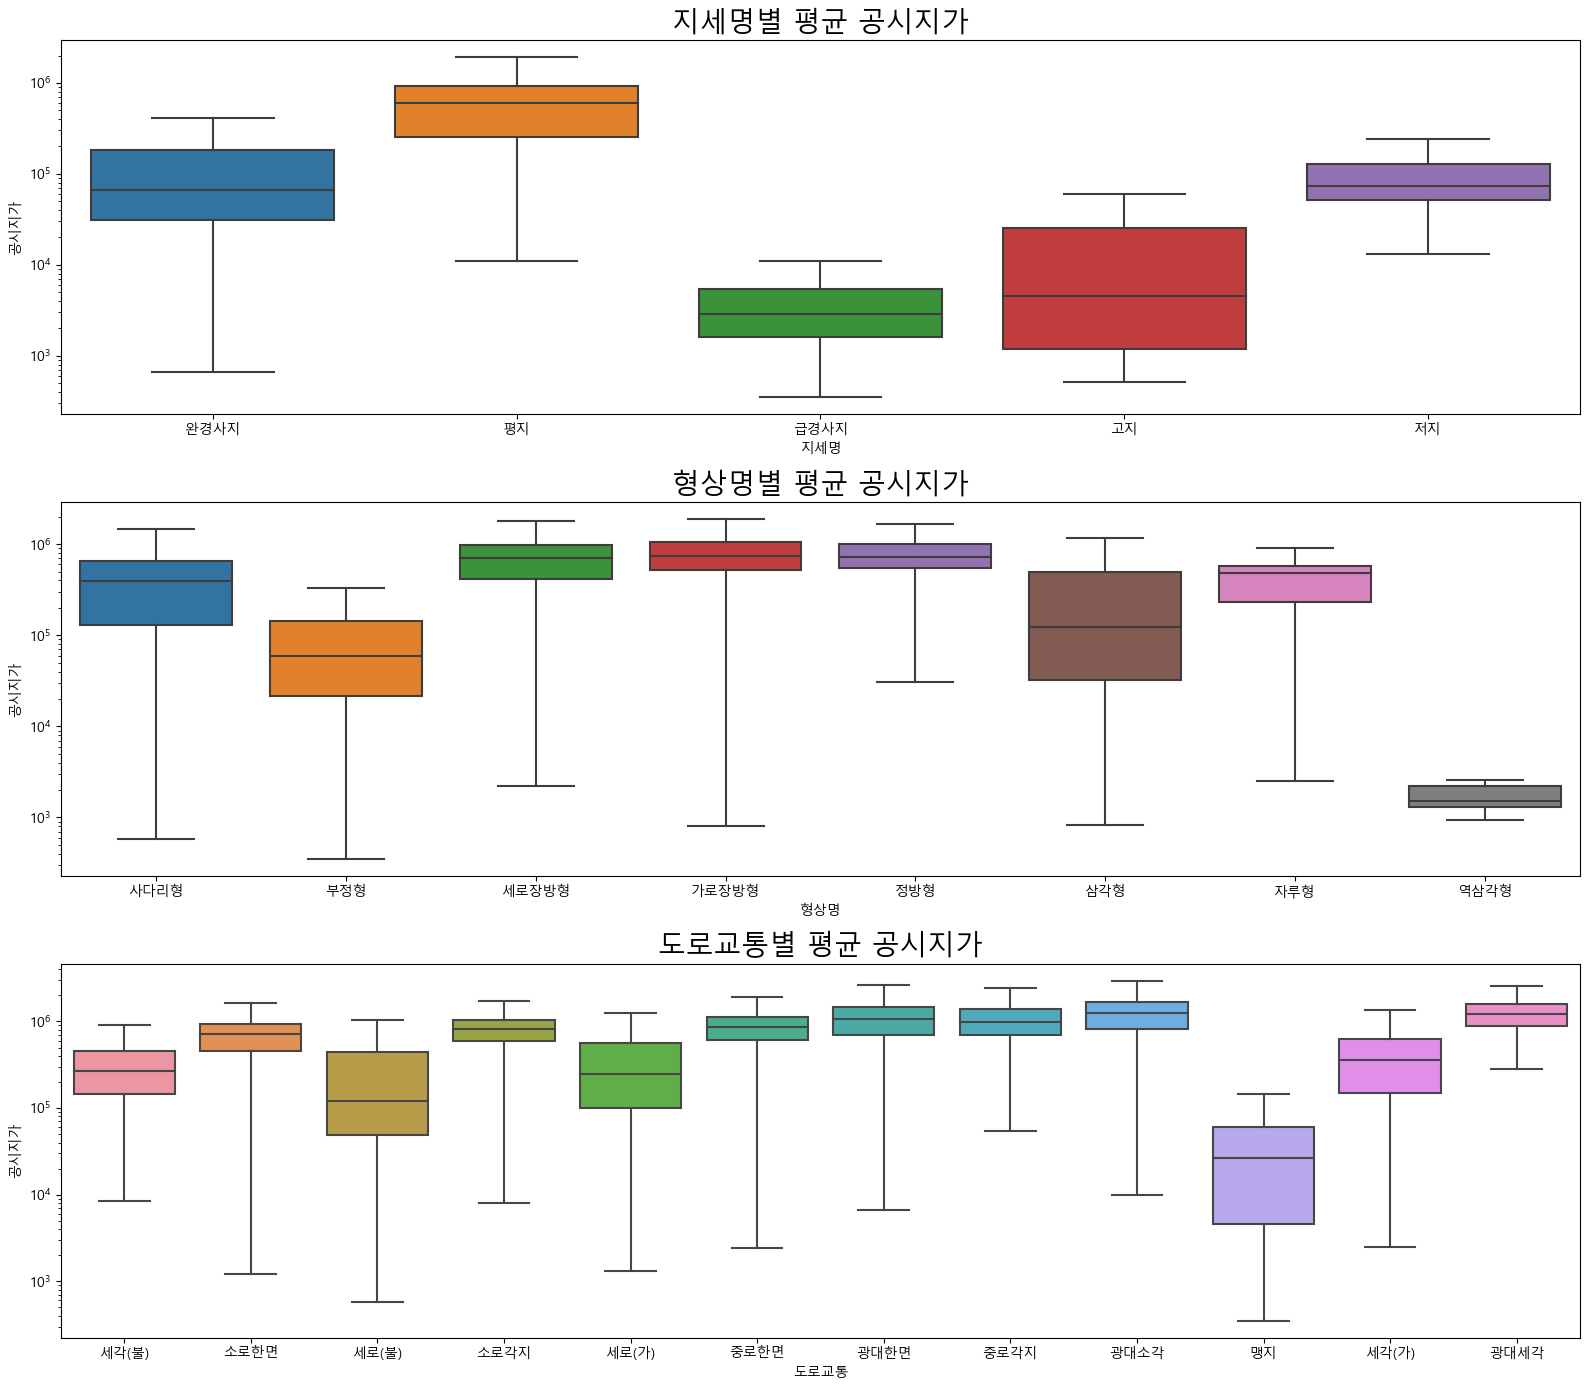

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
lst = ['지세명', '형상명', '도로교통']
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(data=df, x=lst[i], y='공시지가', showfliers=False, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_title(f'{lst[i]}별 평균 공시지가', fontsize=20)
    ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [97]:
# 지세별 평균 공시지가
# 데이터셋 불러오기
shapes = df.groupby(['연도', '지세명'])['공시지가'].mean().reset_index()

# 고유한 지세명과 색상 매핑
color_map = {'고지': 'red', '급경사지': 'blue', '완경사지': 'coral', '저지': 'green', '평지': 'turquoise'}

# 라인 그래프 그리기
fig = go.Figure()
for jise_name, color in color_map.items():
    jise_data = shapes[shapes['지세명'] == jise_name]
    fig.add_trace(go.Scatter(x=jise_data['연도'], y=jise_data['공시지가'], mode='lines', line=dict(color=color), name=jise_name))

# 레이아웃 설정
fig.update_layout(width=1200, height=600,
    title={
        'text': '지세명별 평균 공시지가의 변화',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 35}
    },
    xaxis_title='연도',
    yaxis_title='공시지가',
    legend_title='지세명'
)

fig.show()

In [99]:
# 지세별 평균 공시지가
# 데이터셋 불러오기
shapes = df.groupby(['연도', '형상명'])['공시지가'].mean().reset_index()

# 고유한 지세명과 색상 매핑
color_map = {'가로방장형': 'red', '부정형': 'blue', '사다리형': 'green', '세로장방형': 'coral', '정방형': 'turquoise', '자루형':'magenta', '삼각형':'yellow', '역삼각형':'purple'}

# 라인 그래프 그리기
fig = go.Figure()
for jise_name, color in color_map.items():
    jise_data = shapes[shapes['형상명'] == jise_name]
    fig.add_trace(go.Scatter(x=jise_data['연도'], y=jise_data['공시지가'], mode='lines', line=dict(color=color), name=jise_name))

# 레이아웃 설정
fig.update_layout(width=1200, height=600,
    title={
        'text': '형상별 평균 공시지가의 변화',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 35}
    },
    xaxis_title='연도',
    yaxis_title='공시지가',
    legend_title='형상명'
)

fig.show()

* 광로 : 40m 이상
* 대로 : 25m 이상 40m 미만 
* 중로 : 12m 이상 25m 미만
* 소로 : 8m 이상 12m 미만
* 세로 : 8m 미만

In [46]:
# 도로교통별 평균 공시지가
# 데이터셋 불러오기
shapes = df.groupby(['연도', '도로교통'])['공시지가'].mean().reset_index()

# 고유한 지세명과 색상 매핑
color_map = {'광대세각': 'red', '광대소각': 'blue', '광대한면': 'green', '소로각지': 'coral', '소로한면': 'turquoise', 
             '중로각지': 'magenta', '중로한면': 'yellow', '맹지': 'purple', '세각(가)': 'pink', '세각(불)': 'gold',
             '세로(가)': 'gray', '세로(불)': 'brown'}
# 라인 그래프 그리기
fig = go.Figure()
for jise_name, color in color_map.items():
    jise_data = shapes[shapes['도로교통'] == jise_name]
    fig.add_trace(go.Scatter(x=jise_data['연도'], y=jise_data['공시지가'], mode='lines', line=dict(color=color), name=jise_name))

# 레이아웃 설정
fig.update_layout(width=1200, height=600,
    title={
        'text': '도로교통별 평균 공시지가의 변화',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 35}
    },
    xaxis_title='연도',
    yaxis_title='공시지가',
    legend_title='도로교통'
)

fig.show()

## <b> 3. 모델 학습 및 검증 </b>

# 모델 학습을 위한 데이터 가공

> X, y 분리

In [29]:
# X, y 분리
X_df = df.drop(['공시지가', '가격'], axis=1)
y_df = df['공시지가']
X_2022 = df_2022.drop(['공시지가'], axis=1)
y_2022 = df_2022['공시지가']

> 특성 선택

In [30]:
X_df = X_df.drop(['본번지', '읍면동리', '소재지'], axis=1)
X_2022 = X_2022.drop(['본번지', '부번지', '읍면동리', '소재지'], axis=1)

> 인코딩

In [31]:
# 라벨 인코딩
le = LabelEncoder()
lst = ['시도명', '시군구명', '지목', '용도지역1', '이용상황', '주위환경', '지세명', '형상명', '도로교통']

for i in lst:
    X_df[i] = le.fit_transform(X_df[i].astype(str))
    X_2022[i] = le.fit_transform(X_2022[i].astype(str))


# 수치형 열 표준화
mmscaler = MinMaxScaler()
mmlst = ['면적', '연도']

for i in mmlst:
    X_df[i] = mmscaler.fit_transform(X_df[[i]])
    X_2022[i] = mmscaler.fit_transform(X_2022[[i]])

# original_sc = mmscaler.fit_transform(X_original)
# df_sc = mmscaler.fit_transform(X_df)
# X_2022_sc = mmscaler.fit_transform(X_2022)

# 데이터 나누기 train / val / test / 2022

In [34]:
# df 데이터 나누기
X_train_val, X_test, y_train_val, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1)

print(X_train.shape, X_val.shape, X_test.shape)

(43645, 13) (14549, 13) (14549, 13)


>일반적으로 '공시지가'가 매해 증가한다는 점을 고려하여 선형회귀를 모델로 선정함.

# XGBoost
> 모델 학습 및 val set

Validation Set:
MAE: 24305.873010777093
MSE: 3096756375.9184227
RMSE: 55648.50740063405
MAPE: 0.12560637813278475


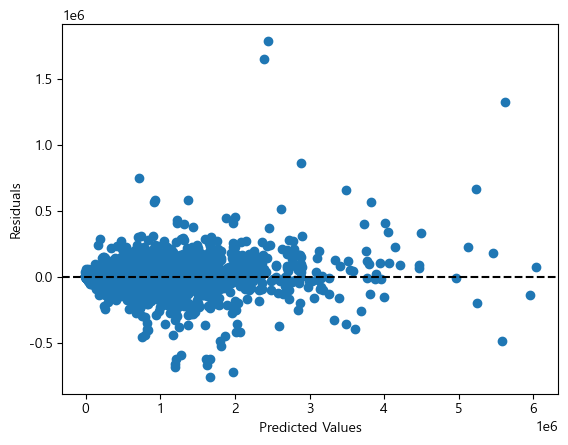

In [35]:
# XGBoost 모델 생성
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', n_estimators=700, max_depth=10, learning_rate=0.1, random_state=1)

# 모델 학습
xgb_model.fit(X_train, y_train)

# 모델 예측
y_pred = xgb_model.predict(X_val)

# 모델 평가
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_val, y_pred)

print('Validation Set:')
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE:', mape)

# 잔차 그래프 그리기
residuals = y_val - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
# plt.xscale('log')
# plt.yscale('log')
plt.show()

> 학습곡선

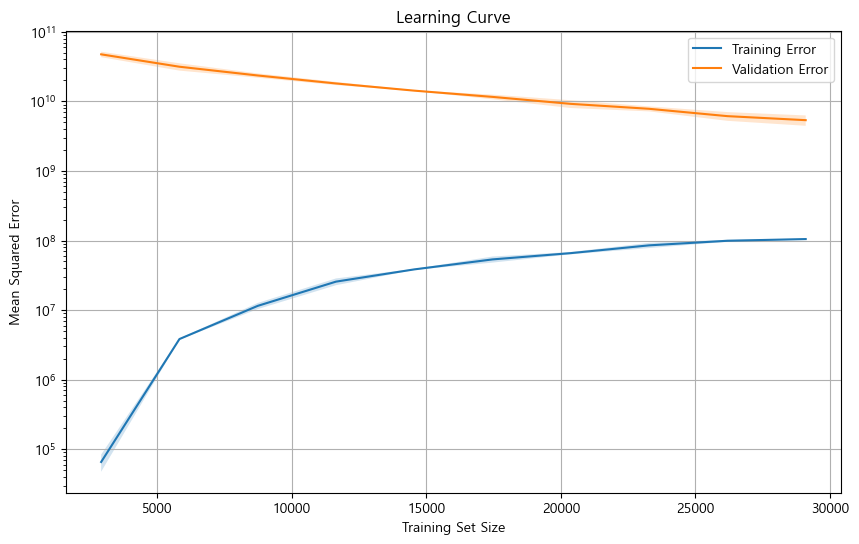

In [54]:
# 학습곡선
sizes, train_scores, val_scores = learning_curve(estimator=xgb_model, X=X_train, y=y_train,
                                                train_sizes=np.linspace(0.1, 1.0, 10),
                                                cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(sizes, train_mean, label='Training Error')
plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(sizes, val_mean, label='Validation Error')
plt.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.yscale('log')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.grid(True)
plt.show()

> 검증곡선

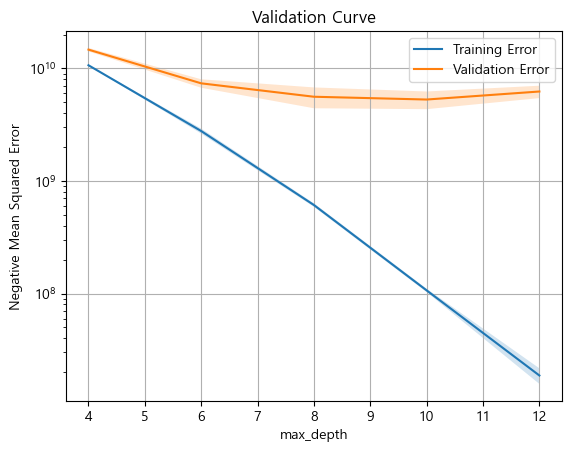

In [55]:
# 검증곡선
param_range = [4, 6, 8, 10, 12]
train_scores, test_scores = validation_curve(xgb_model, X_train, y_train, param_name="max_depth", 
                                             param_range=param_range, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)

train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label='Training Error')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.2)

plt.plot(param_range, test_mean, label='Validation Error')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.2)

plt.yscale('log')
plt.xlabel('max_depth')
plt.ylabel('Negative Mean Squared Error')
plt.title('Validation Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

> XGBoost test set

Test Set:
MAE: 23695.240578715075
MSE: 2761764864.333167
RMSE: 52552.49627118742
MAPE: 0.12938618634266888


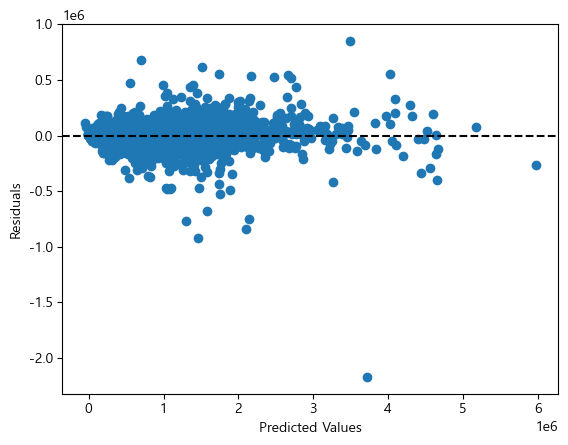

In [22]:
y_test_pred = xgb_model.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print('Test Set:')
print('MAE:', mae_test)
print('MSE:', mse_test)
print('RMSE:', rmse_test)
print('MAPE:', mape_test)

# 잔차 그래프 그리기
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

# XGBoots로 2022년 창원시 공시지가 예측

Test Set:
MAE: 313654.80170070427
MSE: 270820838807.90622
RMSE: 520404.495376343
MAPE: 1.2088580432958567


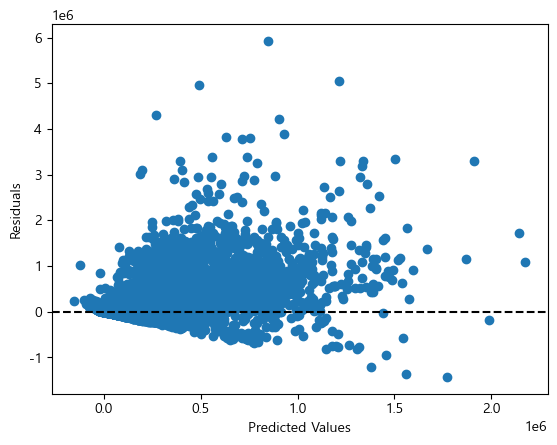

In [36]:
y_test_pred = xgb_model.predict(X_2022)

mse_test = mean_squared_error(y_2022, y_test_pred)
mae_test = mean_absolute_error(y_2022, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_2022, y_test_pred)

print('Test Set:')
print('MAE:', mae_test)
print('MSE:', mse_test)
print('RMSE:', rmse_test)
print('MAPE:', mape_test)

# 잔차 그래프 그리기
residuals = y_2022 - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

# RandomForestRegressor
> 모델 학습 및 val set

Validation Set:
MAE: 37464.02619017002
MSE: 6325844303.04115
RMSE: 79535.17651354746
MAPE: 0.13972892620295416


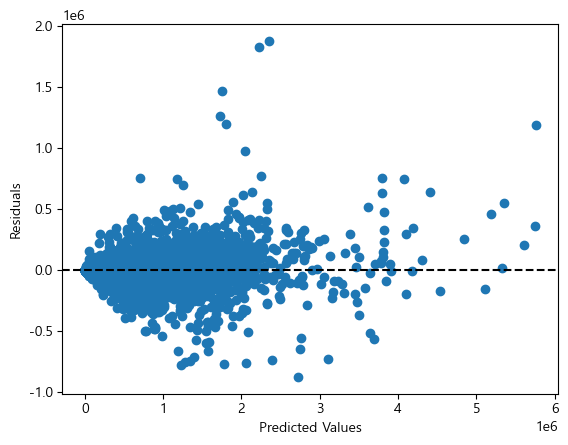

In [58]:
rf = RandomForestRegressor(n_estimators=100, max_depth=24, min_samples_split=4, min_samples_leaf=1, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)
rmse = np.sqrt(mse)

print('Validation Set:')
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE:', mape)

# 잔차 그래프 그리기
residuals = y_val - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

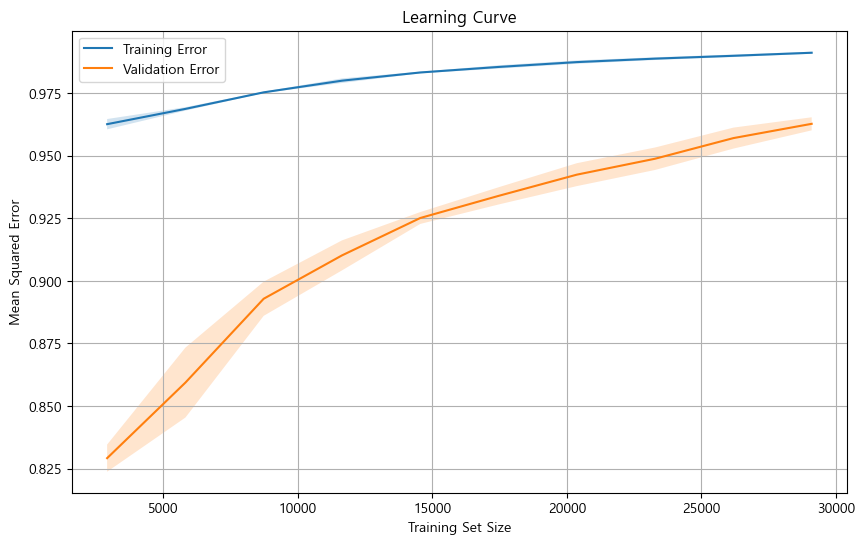

In [59]:
# 학습곡선
sizes, train_scores, val_scores = learning_curve(estimator=rf, X=X_train, y=y_train,
                                                train_sizes=np.linspace(0.1, 1.0, 10),
                                                cv=3, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(sizes, train_mean, label='Training Error')
plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(sizes, val_mean, label='Validation Error')
plt.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.grid(True)
plt.show()

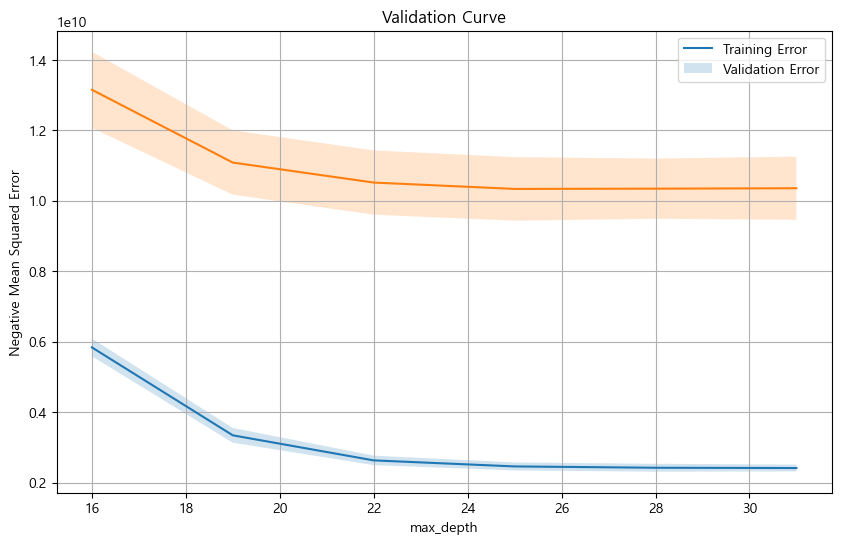

In [60]:
# Define the parameter range to test
param_range = [16,19,22,25,28,31]

# Calculate the training and test scores for different max_depth values
train_scores, test_scores = validation_curve(rf, X_train, y_train, param_name="max_depth", 
                                             param_range=param_range, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)

# Calculate the mean and standard deviation of the training and test scores
train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean)
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.2)

plt.plot(param_range, test_mean)
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.2)

plt.xlabel('max_depth')
plt.ylabel('Negative Mean Squared Error')
plt.title('Validation Curve')
plt.legend(['Training Error', 'Validation Error'])
plt.grid(True)
plt.show()

> test set

Test Set:
MAE: 37367.48480820144
MSE: 5978582224.778844
RMSE: 77321.29218254726
MAPE: 0.1477486452311182


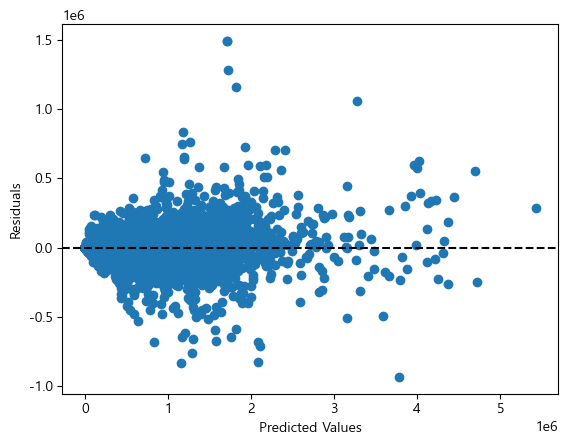

In [61]:
y_test_pred = rf.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print('Test Set:')
print('MAE:', mae_test)
print('MSE:', mse_test)
print('RMSE:', rmse_test)
print('MAPE:', mape_test)

# 잔차 그래프 그리기
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

# RandomForestRegressor 2022년 창원시 공시지가 예측

Test Set:
MAE: 228942.7942794219
MSE: 207813270521.2595
RMSE: 455865.4083402902
MAPE: 1.2833498607910274


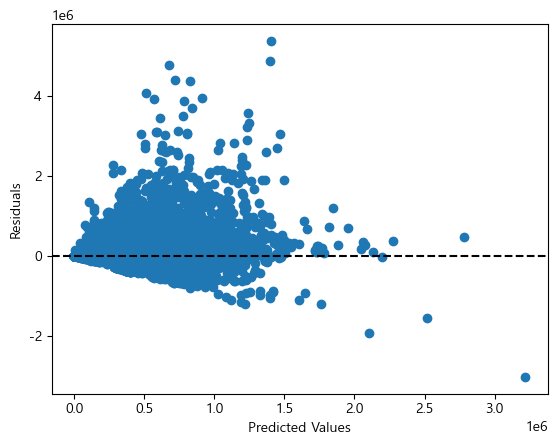

In [62]:
y_test_pred = rf.predict(X_2022)

mse_test = mean_squared_error(y_2022, y_test_pred)
mae_test = mean_absolute_error(y_2022, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_2022, y_test_pred)

print('Test Set:')
print('MAE:', mae_test)
print('MSE:', mse_test)
print('RMSE:', rmse_test)
print('MAPE:', mape_test)

# 잔차 그래프 그리기
residuals = y_2022 - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

## <b> 4. 결과 분석 및 고찰 </b>

* 10년간 전국적인 공시지가의 상승세와 창원시의 10년간 공시지가 상승세가 동일함
* 지목별 면적 분포에서 공장용지가 절반 이상. 임야가 13%
* 평지, 정방형 장방형의 공시지가 상승세가 높았고, 세각 세로를 제외한 도로교통별 공시지가 또한 상승
  
* val과 test 셋은 성능이 잘 나왔으나...
* 방위 및 다른 특성에서 나온 결측치로 인해 모델 학습에 들어가는 특성이 적어짐.